# Simulation

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
from scipy.sparse import csr_matrix

from celloracle.trajectory.oracle_utility import _adata_to_df

In [2]:
import celloracle as co
%matplotlib inline

In [3]:
#plt.rcParams["figure.figsize"] = [9,6]
#%config InlineBackend.figure_format = 'retina'
#plt.rcParams["savefig.dpi"] = 600

In [4]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data

Load data from previous notebook.

In [5]:
#load oracle object
oracle = co.load_hdf5("./Pancreas_data.celloracle.oracle")

In [6]:
#load GRNs, which were saved in the Links obect
links = co.load_hdf5("./links.celloracle.links")

# 2. Make predictive models for simulation

We will fit ridge regression models again (after feature selection using p-values).
This process takes less time than the GRN inference in the previous notebook because we only use significant TFs to predict target gene instead of all regulatory candidate TFs. 

In [7]:
#filter based on the p-value 0.001 default
links.filter_links()

In [8]:
#extract TF and target gene info from links object
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)

In [9]:
#fit GRN
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in Alpha


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 981 genes
calculating GRN in Beta


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 972 genes
calculating GRN in Delta


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 859 genes
calculating GRN in Ductal


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 819 genes
calculating GRN in Epsilon


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 770 genes
calculating GRN in Ngn3 high EP


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 951 genes
calculating GRN in Ngn3 low EP


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 799 genes
calculating GRN in Pre-endocrine


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 1013 genes


## 3. Velocity

In [10]:
scv.tl.recover_dynamics(oracle.adata, n_jobs = 10)

recovering dynamics (using 10/16 cores)


  0%|          | 0/1298 [00:00<?, ?gene/s]

    finished (0:02:01) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [11]:
#compute velocities
scv.tl.velocity(oracle.adata, mode='dynamical')

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [12]:
scv.tl.velocity_graph(oracle.adata)

computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


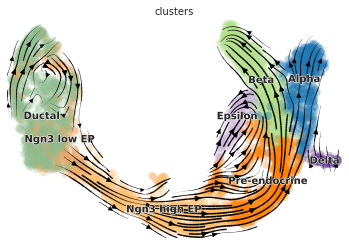

In [13]:
scv.pl.velocity_embedding_stream(oracle.adata, basis='umap')

## 4. Latent time

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


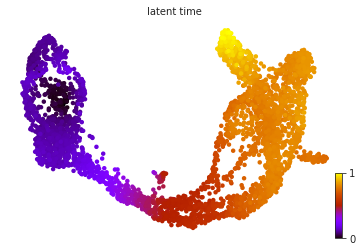

In [14]:
scv.tl.latent_time(oracle.adata)
scv.pl.scatter(oracle.adata, color='latent_time', color_map='gnuplot', size=80)

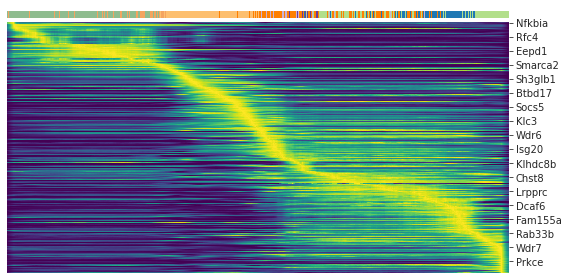

In [15]:
top_genes = oracle.adata.var['fit_likelihood'].sort_values(ascending=False).index#[:300]
scv.pl.heatmap(oracle.adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

In [16]:
scv.tl.rank_dynamical_genes(oracle.adata, groupby='clusters')

ranking genes by cluster-specific likelihoods
    finished (0:00:01) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


In [17]:
# Save oracle object.
oracle.to_hdf5("Pancreas_grn_vel.celloracle.oracle")